# Method to analyze whether SNV in ETS

In [1]:
tfbsType='ETS'
tfName='ETS'

expname='Tewhey'

In [2]:
# import snv_ets_analysis as se

import helper_functions as hf

import scipy.stats as stats
from operator import itemgetter
import copy
import sigfig as sf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os

In [3]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt
                    #.  012345678901234567890
            
# for i in getAll8mers(chr2seq['chr7'], 156791183, 'T', ''):
    # print(i)
            

In [4]:
def ets(kmer4):
    if kmer4 in ['GGAA','GGAT','TTCC','ATCC']: return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2EtsLogic={
    (0,0):'Ets Never',
    (1,1):'Ets Always',
    (0,1):'Ets Created',
    (1,0):'Ets Deleted'
}

In [5]:

def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    etsChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        core   =kmer8[2:6]
        coremut=kmer8mut[2:6]

        ba=(ets(core),ets(coremut)) # before after logic
        etsLogic=BeforeAfter2EtsLogic[ba]

        # If ets-changing snp found, write it out
        if etsLogic=='Ets Always': 
            etsChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return etsLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif etsLogic=='Ets Created':
            return etsLogic,kmer8,kmer8mut
            
        elif etsLogic=='Ets Deleted':
            return etsLogic,kmer8,kmer8mut

    if etsChanged==False:
        return 'Variant not in ETS',kmer8,kmer8mut



# Load ref data

In [6]:
# Ets1
ref  =f'preprocessed-data/parsed_Ets1_8mers.txt'              
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)


# hg38
ref='/Users/joe/code/ref/genomes/human/hg19/online-only/hg19.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAA 0.14700431859740803


# Load MPRA data

In [7]:
fn='preprocessed-data/tewhey-dataframe-input__fdr__withRC.tsv'
df=pd.read_csv(fn,sep='\t')
df.head(2)

,chrom,pos,ref,alt,effect,log-p,p-value
0,chr1,153588340,C,T,-0.124930,0.803895,0.157074
1,chr1,111642031,A,G,-0.092596,0.102546,0.789685


In [8]:
len(df)

3432

In [9]:
## New one which grabs 8mer ref and  8mer alt  regardlesso f snv  type

variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt']]

    if alt=='-': alt=''
    resultList=snv_ets_analysis(chrom,pos,ref,alt,chr2seq,Seq2EtsAff)
    result=resultList[0]
    
    if result=='Variant not in ETS':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Ets')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Ets Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Ets Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)

        
        
    

In [10]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

df['aff-delta']=df.apply(lambda row: row['aff-alt']-row['aff-ref'],axis=1)

In [11]:
df['variant-type'].value_counts()

Not In Ets     2822
Ets Always      236
Ets Deleted     188
Ets Created     186
Name: variant-type, dtype: int64

In [12]:
df['-log(p)']=df['log-p'].apply(lambda logp: logp)
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=0 else -r['-log(p)'],axis=1)

In [13]:
df.loc[df['variant-type']!=False,:].head(5)

,chrom,pos,ref,alt,effect,log-p,p-value,variant-type,aff-ref,aff-alt,aff-fc,kmer-ref,kmer-alt,aff-delta,-log(p),-log(p)*direction
0,chr1,153588340,C,T,-0.124930,0.803895,0.157074,Not In Ets,NaN,NaN,NaN,CCACTGTG,TCACTGTG,NaN,0.803895,-0.803895
1,chr1,111642031,A,G,-0.092596,0.102546,0.789685,Ets Always,0.546127,0.651652,1.193224,CAGGAAAT,CAGGAAGT,0.105525,0.102546,-0.102546
2,chr1,26698747,C,T,-0.120109,0.743469,0.180522,Ets Always,0.135037,0.112980,0.836664,TCATCCTC,TCATCCTT,-0.022056,0.743469,-0.743469
3,chr1,2533552,A,C,-0.365843,1.744575,0.018006,Not In Ets,NaN,NaN,NaN,ATGTTCTT,CTGTTCTT,NaN,1.744575,-1.744575
4,chr1,181019202,C,T,-0.334618,0.973007,0.106413,Not In Ets,NaN,NaN,NaN,CACAGGAT,TACAGGAT,NaN,0.973007,-0.973007


In [14]:
df['variant-type'].value_counts()

Not In Ets     2822
Ets Always      236
Ets Deleted     188
Ets Created     186
Name: variant-type, dtype: int64

In [15]:
df['chrompos']=df['chrom']+df['pos'].apply(str)
print(len(df['chrompos']))
print(len(df['chrompos'].unique()))

3432
3222


In [16]:
# some rsids are present twice. Prioritize keeping the tested variant which is significant. If significant in both direction (gof and lof), then do not use

duplicateChrompos  = [cp for cp in df['chrompos'].unique() if df['chrompos'].tolist().count(cp)>1]
len(duplicateChrompos)

logp5=-np.log10(.05)

keepIndices=[]
duplicateChromposConsidered=[]

nomit=0

for idx in df.index:
    
    cp=df.at[idx,'chrompos']
    
    # if index not a duplicate, simply keep the index
    if cp not in duplicateChrompos:
        keepIndices.append(idx)
        duplicateChromposConsidered.append(cp)
        
    # if you've already analyzed this cp, then skip
    elif cp in duplicateChromposConsidered:
        continue
    
    # if duplicate and haven't seen, choose one of the dups to keep
    else:
        r1,r2=df.loc[df['chrompos']==cp,'-log(p)*direction'].tolist()
        
        r1isgof = r1>logp5
        r2isgof = r2>logp5
        
        r1islof = r1<-logp5
        r2islof = r2<-logp5
        
        r1isns  = (not r1isgof) and (not r1islof)
        r2isns  = (not r2isgof) and (not r2islof)
        
        # if BOTH gof, keep r1
        if r1isgof and r2isgof:
            idxkeep=df.loc[df['chrompos']==cp,:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # if ONE is sig... one is n.s.
        #          ... where r1 is significant
        elif ((r1isgof or r1islof) and r2isns):
            idxkeep=df.loc[(df['chrompos']==cp) & (df['-log(p)*direction']==r1),:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        #          ... where r2 is significant
        elif ((r2isgof or r2islof) and r1isns):
            idxkeep=df.loc[(df['chrompos']==cp) & (df['-log(p)*direction']==r2),:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # if NEITHER sig, keep r1
        elif r1isns and r2isns:
            idxkeep=df.loc[df['chrompos']==cp,:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # OTHERWISE (one sig gof, other is sig lof), omit
        else:
            nomit+=1
            continue
            
print('num omitted',nomit)
print('num kept',len(keepIndices))

df=df.loc[keepIndices,:]

num omitted 28
num kept 3404


In [17]:
print(len(df))
df=df.drop_duplicates()
print(len(df))

3404
3208


# Prediction accuracy vs random (for nature)

In [18]:

fcOptCutoff=1.59
fcDecCutoff=1/fcOptCutoff

pvalCutoff=.05
logSigCutoff=abs(np.log10(pvalCutoff))

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)

deNovoThresh=.15

# get variants to predict on
predDF=df.loc[:,:]

# assign prediction labels
bins=[-np.inf,-logSigCutoff,logSigCutoff,np.inf]
predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

# assign predictions
etsLabels=[]

for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

    # not in tf
    if classification=='Not In Ets':
        anno='not-in-tf'

    # delet tf
    elif classification=='Ets Deleted':
        anno='del-tf'

    elif classification=='Ets Created':

        denovoaff=Seq2EtsAff[kmerMut]

        if denovoaff<deNovoThresh:
            anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

        elif denovoaff>=deNovoThresh:
            anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

    #  dramatic iincrase
    elif fc>=fcOptCutoff:
        anno=f'dramatic-increase\n>={fcOptCutoff}'

    #  dramatic incrase
    elif fc<=fcDecCutoff:
        # print(fc,classification)
        anno=f'dramatic-decrease\n<={fcDecCutoff}'

    # no increase
    elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
        anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'
        # print(anno.replace('\n',' '),fc,classification,kmer,kmerMut)


    else:
        anno='subtle-change'
        # print(anno.replace('\n',' '),fc,classification,kmer,kmerMut)


    etsLabels.append(anno)

predDF['ets-class']=etsLabels

line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

for classi in predDF['ets-class'].unique():
    nClassi=predDF['ets-class'].value_counts()[classi]

    ns,gof,lof=[predDF.loc[predDF['ets-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

    line_out+=hf.write_row([classi.replace('\n',' '),nClassi,ns,gof,lof])

print(line_out)
with open(f'FOR-NATURE-STATS-PREDICTIONS-{expname}-{tfName}__fdr.tsv','w') as f: f.write(line_out)

snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	2643	2042	282	319
no-change-aff <=1.25 >=0.8	129	97	20	12
de-novo-tf-low-aff <0.15	113	93	7	13
de-novo-tf-high-aff >=0.15	61	29	25	7
del-tf	177	123	23	31
dramatic-decrease <=0.6289308176100629	26	11	0	15
dramatic-increase >=1.59	21	13	7	1
subtle-change	38	22	8	8



/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.6289308176100629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	no-change-aff <=1.25 >=0.8	0.3942
not-in-tf+del-tf+dramatic-decrease <=0.6289308176100629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	dramatic-increase >=1.59	2.712e-05



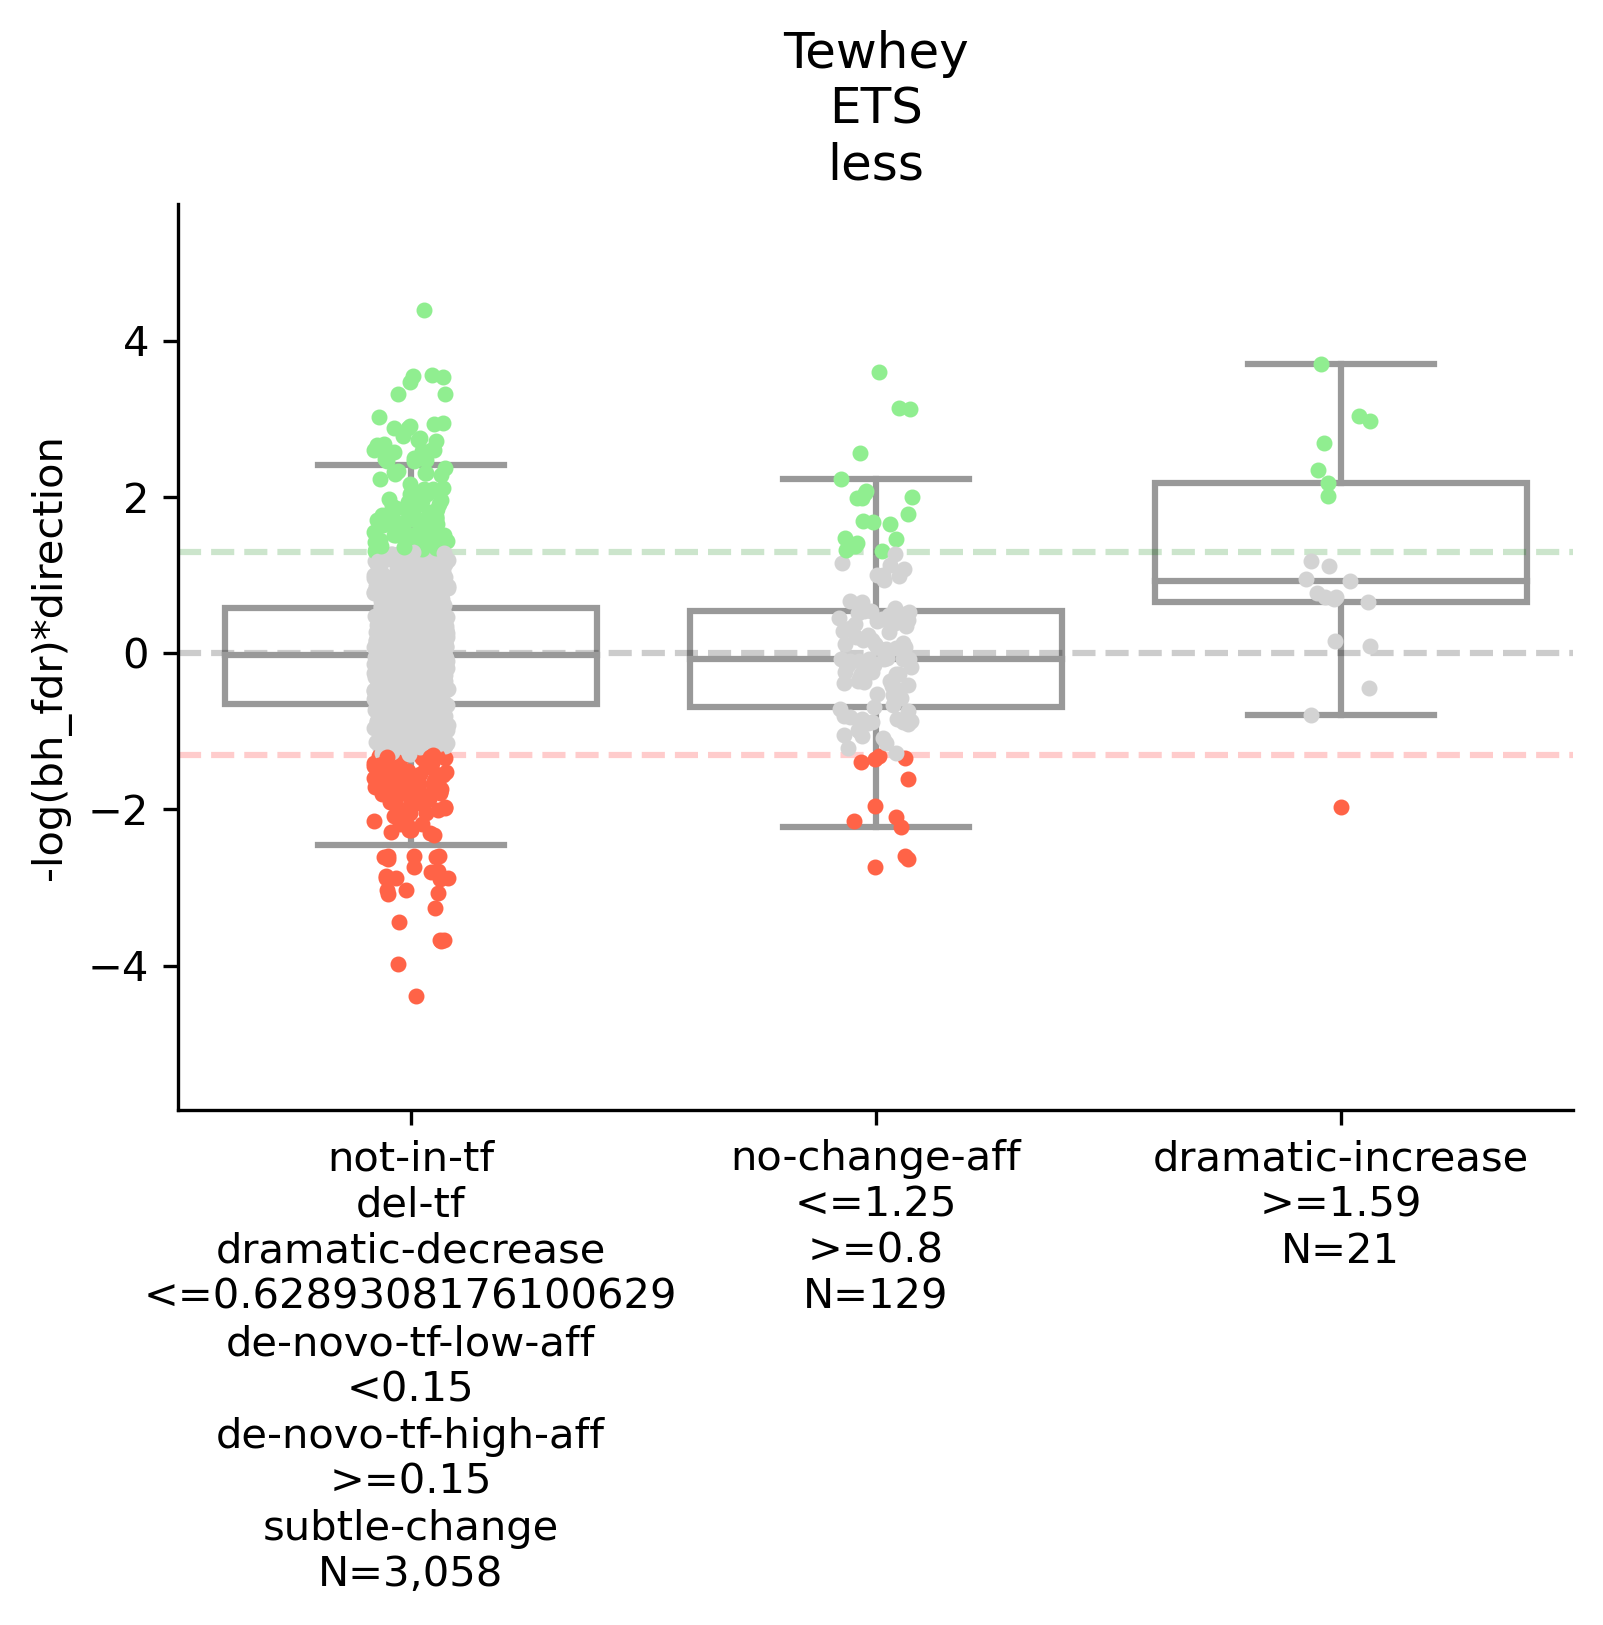

In [19]:
altHypothesis='less'

violin=False
boxplot=True

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}

plotDF=predDF.loc[:,:]




data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        datai+=plotDF.loc[(plotDF['ets-class']==dj),'-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['ets-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['ets-class'].isin(diNameList)),'-log(p)*direction']

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
with open(f'FOR-NATURE__violin-stats__{tfName}__{expname}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

lc=0
for xi,di in enumerate(data):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.08
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{expname}\n{tfName}\n{altHypothesis}')


# plt.savefig(f'/Users/joe/Desktop/ets-kircher-elements={idList}.png')# ,bbox_inches='tight')
plt.show()
      

plotDF.to_csv(f'NATURE-ALL-DATA_{tfName}_{expname}.tsv',sep='\t',index=None)



# Adding in eqtl

In [20]:

fn=f'preprocessed-data/QTD000110__readyForInput__matteoCorrMethod_keepOnlyTewheyMPRAVariants=True_removeMixedGofLofVariants=False_genomeWideSigAdj=True.tsv'

rsid2GeneBetaPvalue={}
rsid2EffectAnnotation={}
rsidList=[]

for _,_,rsid,_,_,beta,pvalue,gene in hf.read_tsv(fn,pc=True,header=False):

    beta=float(beta)
    pvalue=float(pvalue)

    if rsid not in rsid2GeneBetaPvalue:
        rsid2GeneBetaPvalue[rsid]=[]
    rsid2GeneBetaPvalue[rsid].append((gene,beta,pvalue))

    if rsid not in rsid2EffectAnnotation:
        rsid2EffectAnnotation[rsid]=set()

    if beta<0    and pvalue<.05:   rsid2EffectAnnotation[rsid].add('LOF')
    elif beta>0  and pvalue<.05: rsid2EffectAnnotation[rsid].add('GOF')

    rsidList.append(rsid)

print(len(rsidList),len(set(rsidList)))
    



0 chrom
1 pos
2 rsid
3 ref
4 alt
5 beta
6 pvalue-bonf
7 gene-id

77345 2664


In [21]:
chrompos2rsid={}
rsid2cp={}

fn='preprocessed-data//master.geuvadis.annot.parsed.uniq.alleles.reformat.tsv'
rsiddf=pd.read_csv(fn,sep='\t',header=None)
rsiddf.columns=['chrom','pos','rsid','ref','alt','strand']
rsiddf['chrom']='chr'+rsiddf['chrom'].astype(str)

for chrom,pos,rsid in hf.zipdf(rsiddf,['chrom','pos','rsid']):
    chrompos=chrom+str(pos)
    chrompos2rsid[chrompos]=rsid
    rsid2cp[rsid]=(chrom,pos)
    
# rsiddf.tail()



In [22]:
plotDF['rsid']=plotDF['chrompos'].apply(lambda cp: chrompos2rsid[cp])

In [40]:
plotDF.head()

,chrom,pos,ref,alt,effect,log-p,p-value,variant-type,aff-ref,aff-alt,aff-fc,kmer-ref,kmer-alt,aff-delta,-log(p),-log(p)*direction,chrompos,classification,ets-class,rsid
0,chr1,153588340,C,T,-0.124930,0.803895,0.157074,Not In Ets,NaN,NaN,NaN,CCACTGTG,TCACTGTG,NaN,0.803895,-0.803895,chr1153588340,N.S.,not-in-tf,rs11548103
1,chr1,111642031,A,G,-0.092596,0.102546,0.789685,Ets Always,0.546127,0.651652,1.193224,CAGGAAAT,CAGGAAGT,0.105525,0.102546,-0.102546,chr1111642031,N.S.,no-change-aff\n<=1.25\n>=0.8,rs11102212
2,chr1,26698747,C,T,-0.120109,0.743469,0.180522,Ets Always,0.135037,0.112980,0.836664,TCATCCTC,TCATCCTT,-0.022056,0.743469,-0.743469,chr126698747,N.S.,no-change-aff\n<=1.25\n>=0.8,rs112338151
3,chr1,2533552,A,C,-0.365843,1.744575,0.018006,Not In Ets,NaN,NaN,NaN,ATGTTCTT,CTGTTCTT,NaN,1.744575,-1.744575,chr12533552,Sig Decrease,not-in-tf,rs10910099
4,chr1,181019202,C,T,-0.334618,0.973007,0.106413,Not In Ets,NaN,NaN,NaN,CACAGGAT,TACAGGAT,NaN,0.973007,-0.973007,chr1181019202,N.S.,not-in-tf,rs61731104


not-in-tf

[TOTAL] 2181
del-tf

[TOTAL] 153
dramatic-decrease
<=0.6289308176100629

[TOTAL] 22
de-novo-tf-low-aff
<0.15

[TOTAL] 95
de-novo-tf-high-aff
>=0.15

[TOTAL] 53
subtle-change

[TOTAL] 31

[NAN] 0
$$$$$$$$$$$$$$$$$$$$$$$$
no-change-aff
<=1.25
>=0.8

[TOTAL] 110

[NAN] 0
$$$$$$$$$$$$$$$$$$$$$$$$
dramatic-increase
>=1.59

[TOTAL] 18

[NAN] 0
$$$$$$$$$$$$$$$$$$$$$$$$
group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.6289308176100629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	no-change-aff <=1.25 >=0.8	0.9668
not-in-tf+del-tf+dramatic-decrease <=0.6289308176100629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	dramatic-increase >=1.59	0.0001495



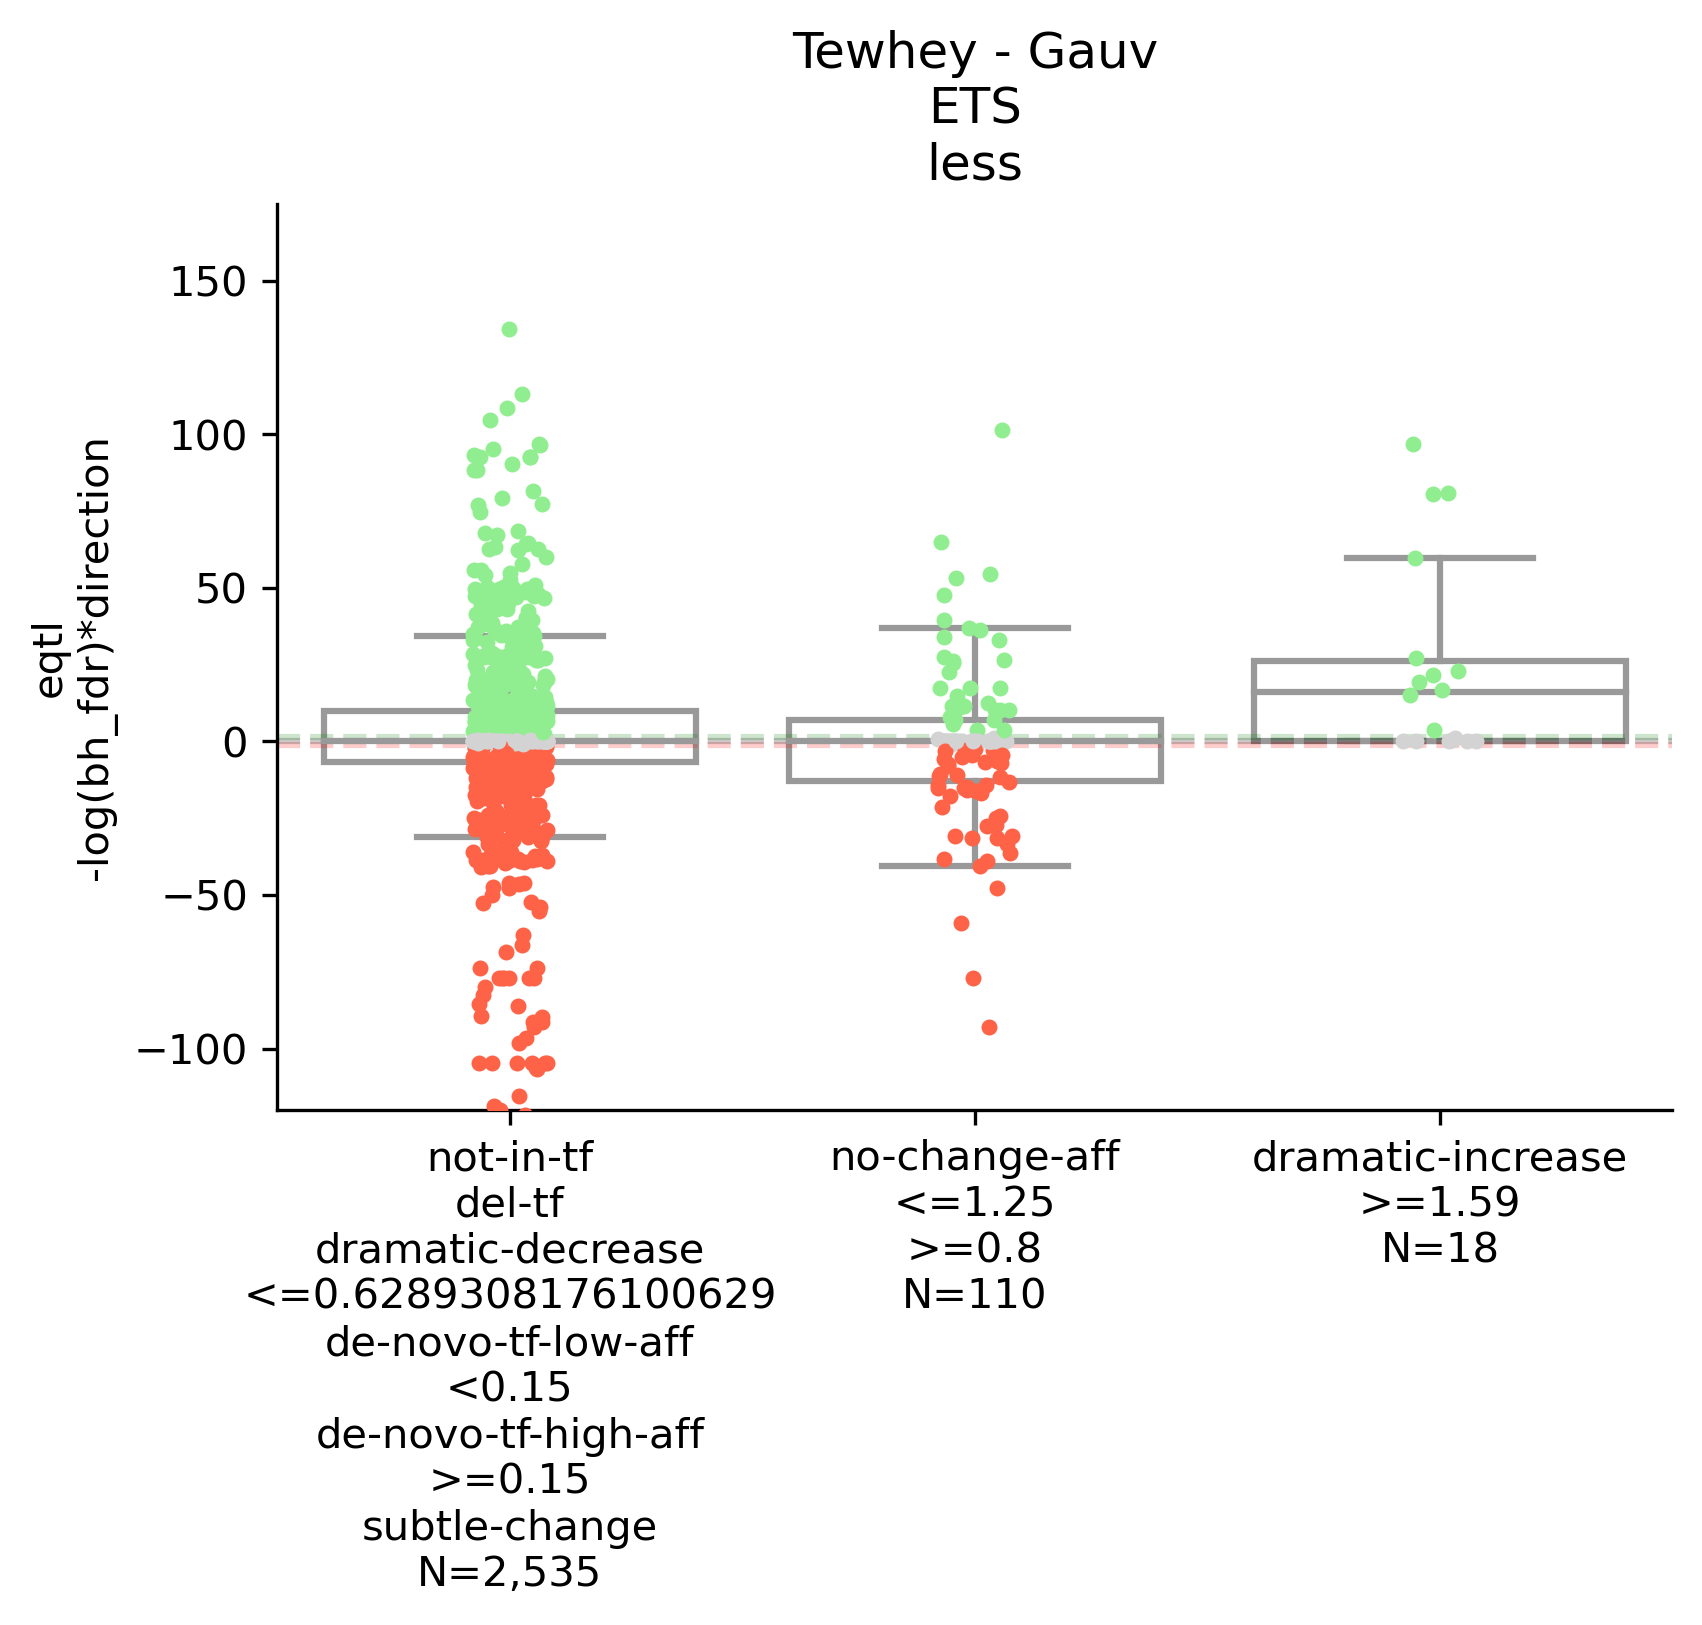

2663


In [44]:
rsid2targetgene={}
rsidUsed=set()
data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        print(dj)
        rsidToInclude=plotDF.loc[(plotDF['ets-class']==dj),'rsid'].tolist()
        
        dataj=[]
        
        for rsid in rsidToInclude:

            if rsid in rsid2GeneBetaPvalue:
                effectList=rsid2GeneBetaPvalue[rsid]
                
                rsidUsed.add(rsid)
                gene,beta,pvalue=sorted(rsid2GeneBetaPvalue[rsid],key=itemgetter(2))[0] # choose most sig variant
                
                rsid2targetgene[rsid]=gene

                if beta>=0: value=-np.log10(pvalue)
                if beta<0: value= np.log10(pvalue)
                
                dataj.append(value)
        print()
        print('[TOTAL]',len(dataj))
        datai.append(dataj)
    print()
    print('[NAN]',len([i for i in datai if str(i)=='nan']))
    print('$$$$$$$$$$$$$$$$$$$$$$$$')
    
    data.append([i for i in datai if str(i)!='nan'])

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

data_plotted=[]
dCtrlNameList=datalabels_subset_v2[0]
dCtrl=copy.copy(data[0])
dCtrl=[i for i in dCtrl if str(i)!='nan']
dCtrl=hf.flatten_list(dCtrl)
data_plotted.append(dCtrl)

for diNameList,di in zip(copy.copy(datalabels_subset_v2[1:]),copy.copy(data[1:])):

    di=[i for i in di if str(i)!='nan']
    di=hf.flatten_list(di)
    data_plotted.append(di)

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
        p=sf.round(p,4)
    except ValueError:
        p='valueError'


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),p])

print(line_out)
with open(f'FOR-NATURE__violin-stats__eqtl__{tfName}__{expname}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

if boxplot:
    sns.boxplot(data=data_plotted,color='white',ax=ax,fliersize=0)#,palette=palette)

lc=0
for xi,di in enumerate(data_plotted):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.08
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data_plotted)])
ax.set_ylabel('eqtl\n-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{expname} - Gauv\n{tfName}\n{altHypothesis}')
ax.set_ylim(-120,175)



# plt.savefig(f'/Users/joe/Desktop/ets-kircher-elements={idList}.png')# ,bbox_inches='tight')
plt.show()


print(len(rsidUsed))
plotDF['target-gene']=plotDF.rsid.apply(lambda rsid: rsid2targetgene[rsid] if rsid in rsid2targetgene else np.NaN)
plotDF.loc[plotDF.rsid.isin(rsidUsed),:].to_csv(f'OCTOBER-NATURE-ALL-EQTL-DATA_{tfName}_{expname}.tsv',sep='\t',index=None)



## Correlation of tewhey mpra with eqtl

In [24]:
optets=plotDF['ets-class']=='dramatic-increase\n>=1.59'
mpragof=plotDF['classification']=='Sig Increase'

rsidListOptEtsAndGofMpra=plotDF.loc[optets & mpragof,'rsid'].tolist()
rsidListOptEtsAndGofMpra,len(rsidListOptEtsAndGofMpra)

(['rs6720375',
  'rs115231472',
  'rs1049927',
  'rs1056008',
  'rs111962081',
  'rs8192793',
  'rs9306233'],
 7)

In [26]:

dogdf=plotDF.loc[optets & mpragof,:].copy(deep=True).set_index('rsid')


In [27]:
lo=hf.getLiftoverObject('hg38','hg19')


In [28]:
mpra=[]
eqtl=[]
rsidPlotted=[]

rsid2rsidCorrect={'rs111962081':'rs62055948'}

eqtlMpraTable={c:[] for c in ['chrom','pos','ref','alt','rsid','aff_fc','mpra_-log(p)*direction','eqtl_-log(p)*direction','eqtl_gene_id']}

for rsid in rsidListOptEtsAndGofMpra:
    
    # make sure effect is one direction for all genes
    if rsid in rsid2EffectAnnotation or rsid2rsidCorrect[rsid] in rsid2EffectAnnotation:
        
        if rsid in rsid2rsidCorrect:
            if rsid2rsidCorrect[rsid] in rsid2EffectAnnotation: 

                rsid2=rsid2rsidCorrect[rsid]
        else:
            rsid2=rsid
        
        if len(rsid2EffectAnnotation[rsid2])==1:

            effectList=rsid2GeneBetaPvalue[rsid]

            for gene,eqtlbeta,eqtlpvalue in effectList:
                if eqtlpvalue>.05: continue
                if eqtlbeta>0: eqtldir=1
                else:          eqtldir=-1
                    
                mpravalue=dogdf.at[rsid,'-log(p)*direction']
                eqtlvalue=-np.log10(eqtlpvalue)*eqtldir
                
                eqtl.append(eqtlvalue)
                mpra.append(mpravalue)
                rsidPlotted.append(rsid)
                
                chrom,pos,ref,alt,aff_fcc = [dogdf.at[rsid,ci] for ci in ['chrom','pos','ref','alt','aff-fc']]
                
                eqtlMpraTable['chrom'].append(chrom)
                eqtlMpraTable['pos'].append(pos)
                eqtlMpraTable['ref'].append(ref)
                eqtlMpraTable['alt'].append(alt)
                
                if rsid in rsid2rsidCorrect:
                    eqtlMpraTable['rsid'].append(rsid2)
                    
                else:
                    eqtlMpraTable['rsid'].append(rsid)
                    
                eqtlMpraTable['aff_fc'].append(aff_fcc)
                eqtlMpraTable['mpra_-log(p)*direction'].append(mpravalue)
                eqtlMpraTable['eqtl_-log(p)*direction'].append(eqtlvalue)
                eqtlMpraTable['eqtl_gene_id'].append(gene)
                
                
        elif len(rsid2EffectAnnotation[rsid2])==0:
            
            mpravalue=dogdf.at[rsid,'-log(p)*direction']
            eqtlvalue=0

            eqtl.append(eqtlvalue)
            mpra.append(mpravalue)
            rsidPlotted.append(rsid)

            chrom,pos,ref,alt,aff_fcc = [dogdf.at[rsid,ci] for ci in ['chrom','pos','ref','alt','aff-fc']]

            eqtlMpraTable['chrom'].append(chrom)
            eqtlMpraTable['pos'].append(pos)
            eqtlMpraTable['ref'].append(ref)
            eqtlMpraTable['alt'].append(alt)
            eqtlMpraTable['rsid'].append(rsid)

            eqtlMpraTable['aff_fc'].append(aff_fcc)
            eqtlMpraTable['mpra_-log(p)*direction'].append(mpravalue)
            eqtlMpraTable['eqtl_-log(p)*direction'].append(eqtlvalue)
            eqtlMpraTable['eqtl_gene_id'].append(gene)
            
        # take most sig variant
        else:
            effectList=rsid2GeneBetaPvalue[rsid2
                                          ]
            for gene,eqtlbeta,eqtlpvalue in sorted(effectList, key=itemgetter(2)):
                
                if eqtlpvalue>.05: continue
                
                if eqtlbeta>0: eqtldir=1
                else:          eqtldir=-1
                    
                mpravalue=dogdf.at[rsid,'-log(p)*direction']
                eqtlvalue=-np.log10(eqtlpvalue)*eqtldir
                
                eqtl.append(eqtlvalue)
                mpra.append(mpravalue)
                rsidPlotted.append(rsid)
                
                chrom,pos,ref,alt,aff_fcc = [dogdf.at[rsid,ci] for ci in ['chrom','pos','ref','alt','aff-fc']]
                
                eqtlMpraTable['chrom'].append(chrom)
                eqtlMpraTable['pos'].append(pos)
                eqtlMpraTable['ref'].append(ref)
                eqtlMpraTable['alt'].append(alt)
                
                if rsid in rsid2rsidCorrect:

                    eqtlMpraTable['rsid'].append(rsid2)
                    
                else:
                    eqtlMpraTable['rsid'].append(rsid)
                    
                eqtlMpraTable['aff_fc'].append(aff_fcc)
                eqtlMpraTable['mpra_-log(p)*direction'].append(mpravalue)
                eqtlMpraTable['eqtl_-log(p)*direction'].append(eqtlvalue)
                eqtlMpraTable['eqtl_gene_id'].append(gene)
                
                break
                

    else:
        mpravalue=dogdf.at[rsid,'-log(p)*direction']

        
    

In [29]:
outmpreeqtldf=pd.DataFrame(eqtlMpraTable)
outmpreeqtldf.head()

,chrom,pos,ref,alt,rsid,aff_fc,mpra_-log(p)*direction,eqtl_-log(p)*direction,eqtl_gene_id
0,chr2,132440073,G,C,rs6720375,2.898456,2.976715,80.585919,ENSG00000287151
1,chr9,131038575,G,C,rs115231472,2.898456,2.687512,21.738576,ENSG00000175854
2,chr9,113018755,T,C,rs1049927,4.531535,2.183497,0.000000,ENSG00000287234
3,chr12,662838,T,C,rs1056008,4.968707,3.707065,96.962018,ENSG00000139044
4,chr17,43852621,T,C,rs62055948,4.784556,3.030931,53.386639,ENSG00000214401


In [30]:
# if rsid-gene sassociation found in more than one dataset (1kg,eur,yri), take the max sig
outmpreeqtldf=outmpreeqtldf.groupby(['chrom','pos','eqtl_gene_id']).max().reset_index()

In [31]:
outmpreeqtldf.to_csv('FOR-NATURE__ETS-TEWHEY-EQTL-TEWHEY-MPRA.tsv',sep='\t',index=False)

Text(0, 0.5, 'eqtl -log(p)*direction')

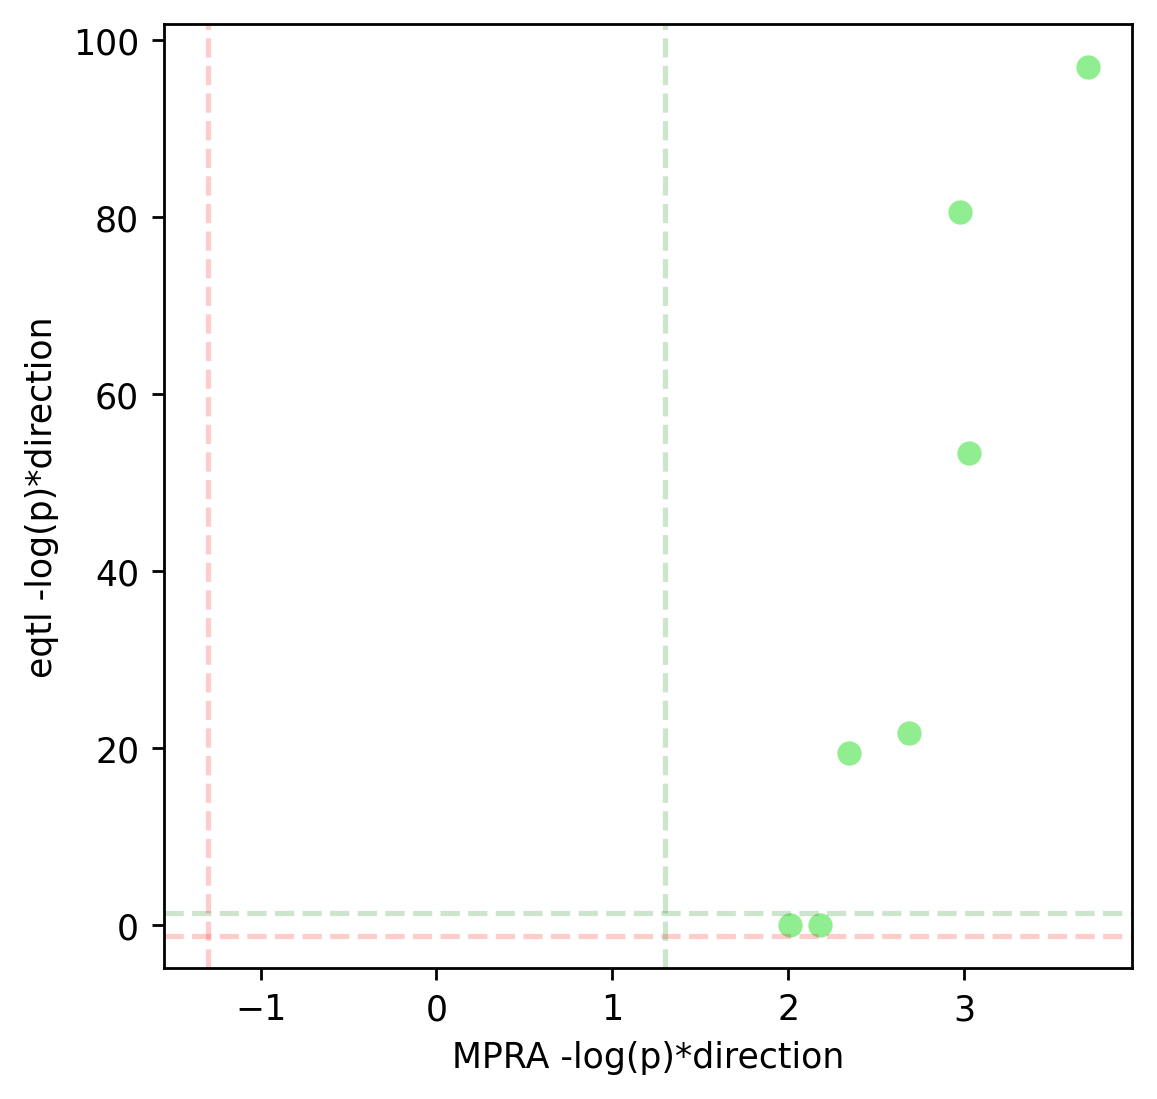

In [32]:
fig,ax=hf.quickfig(5,5,250)

ax.scatter(outmpreeqtldf['mpra_-log(p)*direction'],outmpreeqtldf['eqtl_-log(p)*direction'],color='lightgreen')


ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline( np.log10(.05),ls='--',color='red',alpha=.2  )
ax.axvline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axvline( np.log10(.05),ls='--',color='red',alpha=.2  )

ax.set_xlabel('MPRA -log(p)*direction')
ax.set_ylabel('eqtl -log(p)*direction')